In [1]:
from agents.theoritical_agent import *
from agents.angle_agent import *
from agents.observation_agent import *
from agents.control_rnn import *
from agents.pre_rnn import *
from agents.post_rnn import *
from agents.universal_rnn import *
from env import *
import numpy as np
from tf_to_mat import *

import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

2024-02-02 15:09:20.616390: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-02 15:09:20.642924: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-02 15:09:20.642947: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-02 15:09:20.643555: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-02 15:09:20.647398: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-02 15:09:20.647713: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [2]:
tf.keras.backend.set_floatx('float64')

In [3]:
#Parameters
kappa = 0.5 #Kappa for the von mises
deck_size = 12 #length sequences
optimal_training = False #Training on optimal labels instead of real ones

nb = 1 #Nb of networks to train
batch_size = 2000 #Batch size for the training (length of the training)
rnn_noise = 0.3 #Std for noisy networks (put None if you don't want a noisy network)
random_training = True #Training on sequence of random length chosen uniformely in [|1,12|]
separated_params = (10,2) #(Nb of neurons which will see the first part of the input,size of the first part of the input)

free_feedback = True #True = free feedback in the recurrent network / False = only REF -> SEQ feedbacks

activation = 'tanh' #Activation function

separated = False #Separated network

condition = 'pre'

In [4]:
if optimal_training:
    random_training = False #Random training cannot be used with random_training (technical issues)

### Training

In [7]:
env = Env(deck_size,kappa=kappa,condition=condition)
agent = PreRNN(64,activation=activation,noise=rnn_noise)
agent.postname = condition #Set path name for saving and loading

In [8]:
agent.train(env,1000,batch_size=batch_size,nb_fit=5,verbose=1)
agent.save('UniversalRNN-'+str(condition))

0 0.506
1 0.511
2 0.5101666666666667
3 0.5065
4 0.5077999999999999
5 0.5055
6 0.5032857142857142
7 0.5031875
8 0.5030555555555556
9 0.5026499999999999
10 0.5024
11 0.5001
12 0.49849999999999994
13 0.5005499999999999
14 0.50025
15 0.5003
16 0.50145
17 0.5007499999999999
18 0.5020499999999999
19 0.50065
20 0.49945000000000006
21 0.5001
22 0.5033500000000001
23 0.50065
24 0.5015000000000001
25 0.5000500000000001
26 0.503
27 0.5059500000000001
28 0.5081
29 0.51445
30 0.52005
31 0.5226500000000001
32 0.5256000000000001
33 0.5312
34 0.5361499999999999
35 0.54255
36 0.5454500000000001
37 0.5485000000000001
38 0.5501500000000001
39 0.55105
40 0.55335
41 0.55545
42 0.5551
43 0.5589000000000001
44 0.5591000000000002
45 0.5597000000000001
46 0.5629500000000001
47 0.5655500000000001
48 0.5688500000000001
49 0.56795
50 0.5667500000000001
51 0.5706
52 0.5729
53 0.5728
54 0.5724500000000001
55 0.5754
56 0.5727
57 0.5728
58 0.5715999999999999
59 0.5757000000000001
60 0.5771
61 0.57535
62 0.5774
63 0.5

KeyboardInterrupt: 

In [9]:
agent.save('UniversalRNN-'+str(condition))

SAVING ['nn', 'out_nn']


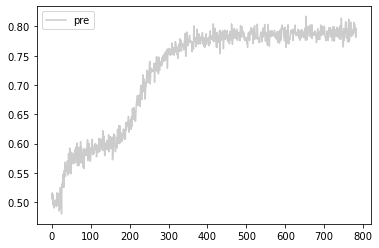

In [10]:
#Plot accuracies
plt.plot(range(len(agent.scores)),agent.scores,alpha=0.4,color='grey',label=condition)
plt.legend()
plt.show()

### Plots

In [5]:
env = Env(deck_size,kappa=kappa,condition=condition)
agent = UniversalRNN(64,activation=activation,noise=rnn_noise)
agent.postname = condition #Set path name for saving and loading

In [6]:
agent.load('UniversalRNN-'+str(condition))

LOADING ['nn', 'out_nn']


In [7]:
from sklearn.decomposition import PCA
from analyse.plot_pca import *

In [8]:
pca_batch_size = 2000 #Batch size to fit the PCA on
pca_axes = [0,1,2] #Axes of the pca to plot (3 max)

nb_variance = 10 #Nb of variance to plot

In [9]:
#Pre compute batch
batch_obsf = env.sample_batch(pca_batch_size) 
batch_obs = batch_obsf.get('obs')

In [10]:
#Def residue function
def residue(X,Y):
    from sklearn.linear_model import LinearRegression
    Lg = LinearRegression()
    XX = np.reshape(X,(-1,X.shape[-1]))
    YY = Y
    Lg.fit(YY,XX)
    print("score",Lg.score(YY,XX))
    #assert False
    pred = Lg.predict(YY)
    pred = np.reshape(pred,X.shape)
    return X - pred

In [90]:
out = agent.nn(batch_obs).numpy()[:,-1:,:]
choice = agent.predict(batch_obsf).numpy()

In [91]:
batch_obsf.get('ref')

array([4.71238898, 3.92699082, 0.78539816, ..., 1.57079633, 3.14159265,
       4.71238898])

In [98]:
#Residue ref
#cosref = np.cos(batch_obsf.get('ref'))[:,None]
#sinref = np.sin(batch_obsf.get('ref'))[:,None]
#ref = np.concatenate([cosref,sinref],axis=1)
#ref = ref[:,None,:].repeat(out.shape[1],axis=1).reshape((-1,2))
#out = residue(out,ref)

#Residue choice
choice_batch = choice[:,None].repeat(out.shape[1],axis=1).reshape((-1,1))
out = residue(out, choice_batch)

#Residue mean angle
#mean_angle = np.mean(batch_obsf.get('obs')[:,:,:2],axis=1)[:,None,:].repeat(out.shape[1],axis=1).reshape((-1,2))
#out = residue(out,mean_angle)

score 0.050415520630178165


In [99]:
#fit pca
pca = fit_pca(out.reshape((-1,64)),nb_components=nb_variance)
pca_batch = pca.transform(out.reshape((-1,64))).reshape(out.shape[:-1]+(nb_variance,))

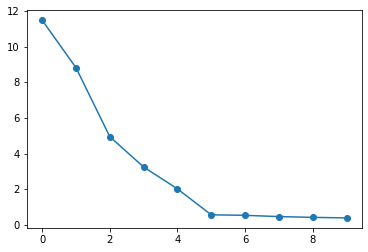

In [100]:
%matplotlib inline
#plot explained variance
plt.plot(range(nb_variance),pca.explained_variance_,marker='o')
plt.show()

In [94]:
batch_obsf.get('mean')

array([[7.85398163, 7.85398163, 7.85398163, ..., 7.85398163, 7.85398163,
        7.85398163],
       [7.06858347, 7.06858347, 7.06858347, ..., 7.06858347, 7.06858347,
        7.06858347],
       [0.78539816, 0.78539816, 0.78539816, ..., 0.78539816, 0.78539816,
        0.78539816],
       ...,
       [1.57079633, 1.57079633, 1.57079633, ..., 1.57079633, 1.57079633,
        1.57079633],
       [3.14159265, 3.14159265, 3.14159265, ..., 3.14159265, 3.14159265,
        3.14159265],
       [4.71238898, 4.71238898, 4.71238898, ..., 4.71238898, 4.71238898,
        4.71238898]])

In [95]:
plt.get_cmap('rainbow')(0),plt.get_cmap('rainbow')(1)

((0.5, 0.0, 1.0, 1.0),
 (0.49215686274509807, 0.012319659535238442, 0.9999810273487268, 1.0))

In [96]:
#Plot background function
def plot_bg(pca_batch,zorder=0):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111, projection='3d')
    ax.set_xlabel('pca1')
    ax.set_ylabel('pca2')
    ax.set_zlabel('pca3')
    colors = [(i/deck_size,(1-i/deck_size),(i-6)**2/36) for i in range(pca_batch.shape[1])]
    cm = plt.get_cmap('rainbow')
    #obj = batch_obsf.get('mean')[:,0]/(2*np.pi)
    #obj = batch_obsf.get('ref')/(2*np.pi)
    obj = batch_obsf.get('color')/0.5
    obj = choice/0.5
    colors = [[cm(ref) for ref in obj] for i in range(pca_batch.shape[1])]
    unique_refs = np.unique(obj)
    for i,r in enumerate(unique_refs):
        c = cm(r)
        label = str(r)
        ax.plot([0],[0],[0],color=c,label=label,zorder=zorder)
    for i in range(pca_batch.shape[1]):
        ax.scatter(pca_batch[:,i,3],pca_batch[:,i,4],pca_batch[:,i,0],color=colors[i],alpha=0.1,marker='.',zorder=zorder)

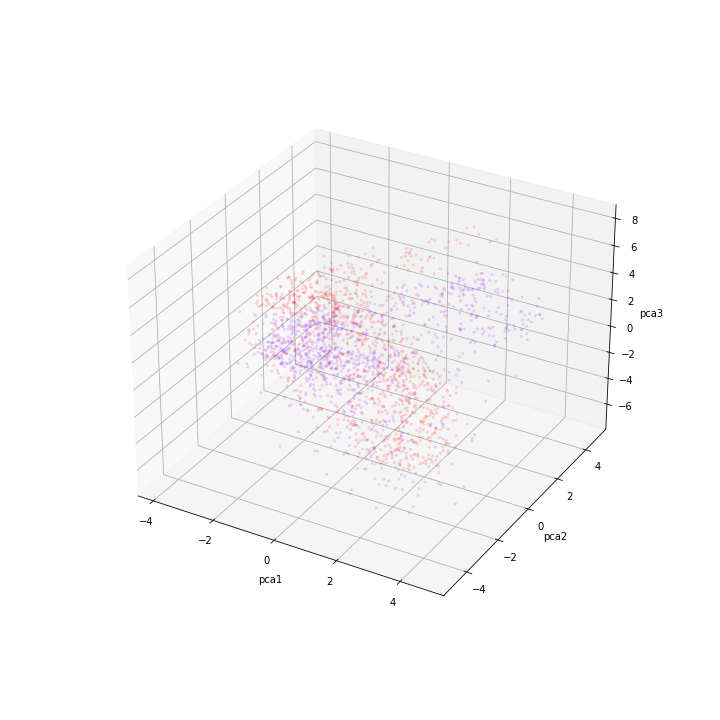

In [101]:
%matplotlib widget
from mpl_toolkits import mplot3d
plot_bg(pca_batch)
plt.show()